In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
! cp -r ./drive/MyDrive/ESM/esm/* .

In [3]:
import random
from collections import Counter
from tqdm import tqdm

import torch
from torch import nn 
from torch.utils.data import Dataset,DataLoader,TensorDataset


import numpy as np
import pandas as pd
import seaborn as sns

import esm

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [60]:
data_mul = pd.read_csv("./multiple_muts_train.csv", )
data_single = pd.read_csv("./single_muts_train.csv")

data = pd.concat((data_mul, data_single), axis=0)
data["name"] = ["protein" + str(i) for i in range(data.shape[0])]

data = data.loc[:, ["name", "sequence", "secondary_structure", "stabilityscore"]]
data.reset_index(drop=True, inplace=True)


# Store the proteins as .fasta file
with open("dataset.fasta", "w") as f:
    for i in range(data.shape[0]):
        f.write(">"+data.loc[i, "name"]+"\n")
        f.write(data.loc[i, "sequence"]+"\n")

In [61]:
nan_list = []
for i in range(data.shape[0]):
  if np.isnan(np.array(data.loc[i, "stabilityscore"])):
    nan_list.append(i)
data = data.drop(nan_list)
data.reset_index(drop=True, inplace=True)

In [62]:
data.shape

(37706, 4)

In [63]:
device = "cuda"

In [64]:
! python extract.py esm1b_t33_650M_UR50S dataset.fasta ./train_all_reprs/ --include per_tok

tcmalloc: large alloc 2609438720 bytes == 0x562fa9fec000 @  0x7f02a761eb6b 0x7f02a763e379 0x7f0253cf725e 0x7f0253cf89d2 0x7f02915c08a5 0x7f02a27d6699 0x562f0a0fdc25 0x562f0a0be7f2 0x562f0a131d75 0x562f0a12ce0d 0x562f0a0bf38b 0x562f0a0bee99 0x562f0a20670d 0x562f0a17557b 0x562f0a0bdf41 0x562f0a1af99d 0x562f0a131fe9 0x562f0a12ce0d 0x562f09ffee2b 0x562f0a12f1e6 0x562f0a12cb0e 0x562f0a0bf77a 0x562f0a12e86a 0x562f0a12cb0e 0x562f0a0bf77a 0x562f0a12e86a 0x562f0a0bf69a 0x562f0a12da45 0x562f0a0bf69a 0x562f0a12da45 0x562f0a0bf69a
tcmalloc: large alloc 2609438720 bytes == 0x56304587a000 @  0x7f02a761eb6b 0x7f02a763e379 0x7f0253cf725e 0x7f0253cf89d2 0x7f02915c08a5 0x7f02a27d6699 0x562f0a0fdc25 0x562f0a0be7f2 0x562f0a131d75 0x562f0a12ce0d 0x562f0a0bf38b 0x562f0a0bee99 0x562f0a20670d 0x562f0a17557b 0x562f0a0bdf41 0x562f0a1af99d 0x562f0a131fe9 0x562f0a12ce0d 0x562f09ffee2b 0x562f0a12f1e6 0x562f0a12cb0e 0x562f0a0bf77a 0x562f0a12e86a 0x562f0a12cb0e 0x562f0a0bf77a 0x562f0a12e86a 0x562f0a0bf69a 0x562f0a12

In [65]:
SS = []
dict = {"H": 0, "E": 1, "T": 2}
for i in range(data.shape[0]):
  ss = data.loc[i, "secondary_structure"]
  s = np.array([dict[ss[i]] for i in range(len(ss))])
  SS.append(torch.from_numpy(s))


## Predict Contact Maps

In [13]:
!pip install git+https://github.com/facebookresearch/esm.git
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593_reprs.tar.gz
!tar -xzf P62593_reprs.tar.gz
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593.fasta
!pwd
!ls
!pip install Bio
!git clone https://github.com/facebookresearch/esm

import sys
PATH_TO_REPO = "../"
sys.path.append(PATH_TO_REPO)

  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-69bxwvvm
  Running command git clone -q https://github.com/facebookresearch/esm.git /tmp/pip-req-build-69bxwvvm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for fair-esm: filename=fair_esm-0.3.1-cp37-none-any.whl size=35777 sha256=49519a3064de9fe6e21201e4b28ec9c7df6a50c99f5365b716fdebcb121d1d71
  Stored in directory: /tmp/pip-ephem-wheel-cache-30kuqx5_/wheels/68/f1/02/8c8e4fea902cc926d482415aa393f6dc1eb1a41d2d78e1ec75
Successfully built fair-esm


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.5M  100 24.5M    0     0  14.6M      0  0:00:01  0:00:01 --:--:-- 14.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1719k  100 1719k    0     0  1877k      0 --:--:-- --:--:-- --:--:-- 1875k
/content
CODE_OF_CONDUCT.rst  hubconf.py		      README.md
CONTRIBUTING.md      LICENSE		      sample_data
dataset.fasta	     multiple_muts_train.csv  setup.py
drive		     P62593.fasta	      single_muts_train.csv
esm		     P62593_reprs	      train_all_reprs
examples	     P62593_reprs.tar.gz
extract.py	     pyproject.toml
     |████████████████████████████████| 81kB 5.2MB/s 
     |████████████████████████████████| 2.3MB 11.9MB/s 
fatal: destination path 'esm' already exists and is not an empty directory.


In [14]:
import matplotlib.pyplot as plt
import esm
import torch
import os
from Bio import SeqIO
import itertools
from typing import List, Tuple
import string
import math

In [15]:
esm1b, esm1b_alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
esm1b = esm1b.eval().cuda()
esm1b_batch_converter = esm1b_alphabet.get_batch_converter()

In [66]:
esm1b_data = []
for i in range(data.shape[0]):
  esm1b_data.append((data.loc[i, "name"], data.loc[i, "sequence"]))

contacts = []
torch.set_grad_enabled(False)
for i in range(math.ceil(len(esm1b_data) / 10)):

  esm1b_batch_labels, esm1b_batch_strs, esm1b_batch_tokens = esm1b_batch_converter(esm1b_data[10 * i : 10 * (i + 1)])
  esm1b_batch_tokens = esm1b_batch_tokens.cuda()
  esm1b_contacts = esm1b.predict_contacts(esm1b_batch_tokens).cpu()
  contacts.append(esm1b_contacts)
torch.set_grad_enabled(False)
contacts = torch.cat(contacts, dim=0)

In [67]:
torch.set_grad_enabled(True)

## Training

In [68]:

EMB_PATH = "./train_all_reprs/"
EMB_LAYER = 33

class ProteinData(Dataset):
        
    def __len__(self):
        return data.shape[0]
    
    def __getitem__(self,i):
        x = torch.load(EMB_PATH + data.loc[i, "name"] + ".pt")["representations"][33]
        
        c = contacts[i, :, :]
        y = data.loc[i, "stabilityscore"]
        label = torch.tensor(y).float()
        return (x,label,c,SS[i])

    
ds_train = ProteinData()



In [69]:
train_size = int(len(ds_train) * 0.7)
test_size = len(ds_train) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(ds_train, [train_size, test_size], generator=torch.Generator().manual_seed(42))

dl_train = DataLoader(train_dataset, batch_size = 128, shuffle=True, drop_last=True)
dl_test = DataLoader(test_dataset, batch_size = 128, shuffle=True, drop_last=True)

In [70]:
class LSTMs(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(3, 5)
        self.lstm0 = nn.LSTM(input_size = 5, 
                             hidden_size = 5,
                             num_layers = 2,
                             batch_first = True,
                             bidirectional = True,
                             dropout = 0.3
                            )
        self.lstm1 = nn.LSTM(input_size = 1280, 
                             hidden_size = 100,
                             num_layers = 2,
                             batch_first = True,
                             bidirectional = True,
                             dropout = 0.3
                            )
        

        self.lstm2 = nn.LSTM(input_size = 210, 
                             hidden_size = 100,
                             num_layers = 2,
                             batch_first = True,
                             bidirectional = True,
                             dropout = 0.3
                            )
        self.linear1 = nn.Linear(200, 1)

        self.cont_w = nn.Parameter(torch.randn([1, 43, 43]))
        self.cont_b = nn.Parameter(torch.randn([1, 43, 43]))
        self.cont_w_ss = nn.Parameter(torch.randn([1, 43, 43]))
        self.cont_b_ss = nn.Parameter(torch.randn([1, 43, 43]))


    def forward(self, x, cont, ss):
      
        y = self.lstm1(x)[0]
        cont_x = self.cont_w * cont + self.cont_b
        y2 = torch.matmul(cont_x, y)
        ss = self.embedding(ss)
        ss = self.lstm0(ss)[0]
        cont_ss = self.cont_w_ss * cont + self.cont_b_ss
        y3 = torch.matmul(cont_ss, ss)

        y = torch.cat((y, ss), dim=2)

        y = self.lstm2(y)[0]

        y = torch.mean(y, dim=1)

        y = self.linear1(y)

        return y
        


In [71]:
model = LSTMs().to(device)

for m in model.modules():
    if isinstance(m, (nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
    if isinstance(m, (nn.LSTM)):
        for name, param in m.named_parameters():
          if 'weight' in name:
            nn.init.orthogonal_(param)
                
#model.load_state_dict(torch.load("./drive/MyDrive/ESM/LSTM_with_Contact_Map.pkl"))


In [72]:
Loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=0.)

In [73]:
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group["params"]:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [74]:
def train_step(model, features, labels, cont, ss):

    model.train()

    optimizer.zero_grad()

    predictions = model(features.to(device), cont.to(device), ss.to(device))
    loss = Loss(predictions, labels.reshape(-1, 1).to(device))
    loss.backward()
    clip_gradient(optimizer, 10)
    optimizer.step()

    pccs = pearsonr(predictions.reshape(-1).detach().cpu().numpy(), labels.reshape(-1).detach().cpu().numpy())
    return loss.item(), pccs[0]

def valid_step(model, features, labels, cont, ss):

    model.eval()

    with torch.no_grad():
        predictions = model(features.to(device), cont.to(device), ss.to(device))
        loss = Loss(predictions, labels.reshape(-1, 1).to(device))
    
    return loss.item(), predictions


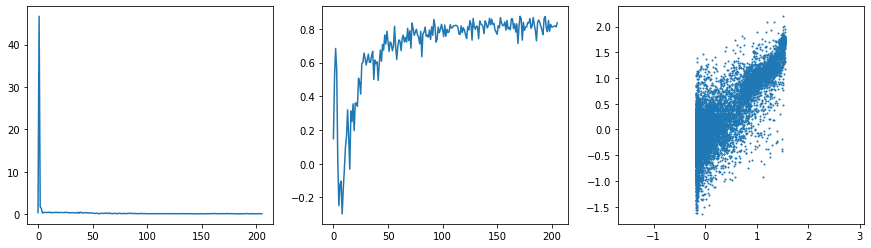

valid loss:  0.14897803208706054
valid correlation:  0.8104311165863107
sota!


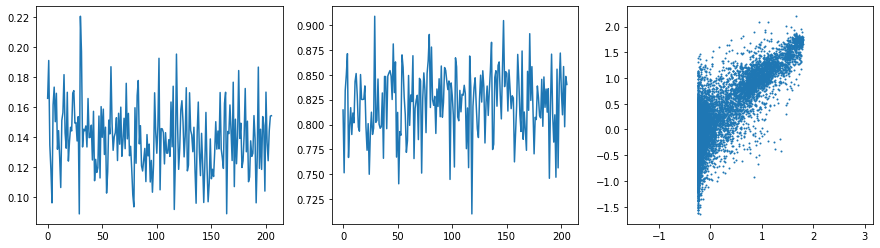

valid loss:  0.13948571055450223
valid correlation:  0.8232117360052038
sota!


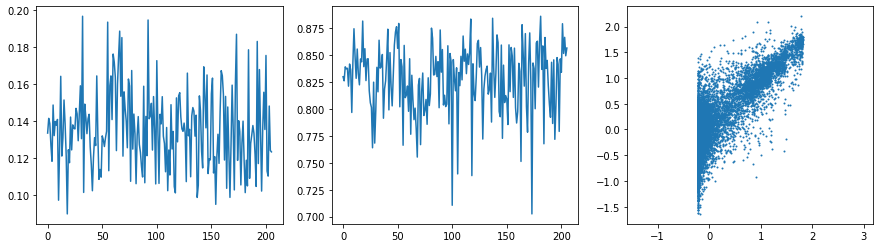

valid loss:  0.13488275202160532
valid correlation:  0.8270067592745182
sota!


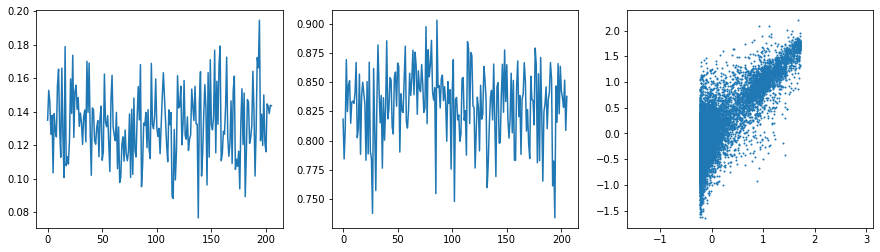

valid loss:  0.1309893805194985
valid correlation:  0.8294000896802782
sota!


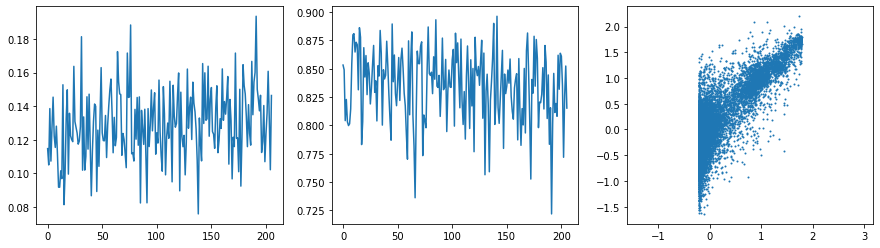

valid loss:  0.13132046510211445
valid correlation:  0.828651577906167


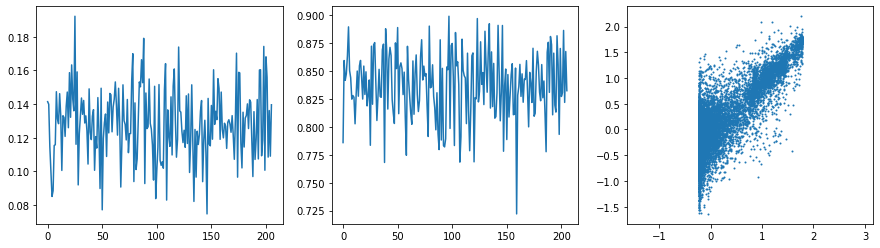

valid loss:  0.137382626618174
valid correlation:  0.8278775107205312


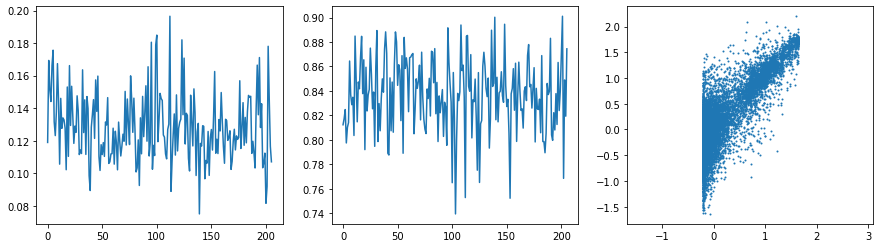

valid loss:  0.12900718521665444
valid correlation:  0.8329823213896881
sota!


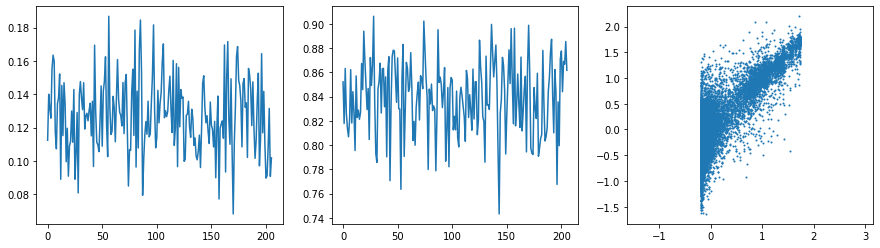

valid loss:  0.12936605419963598
valid correlation:  0.831386933473804


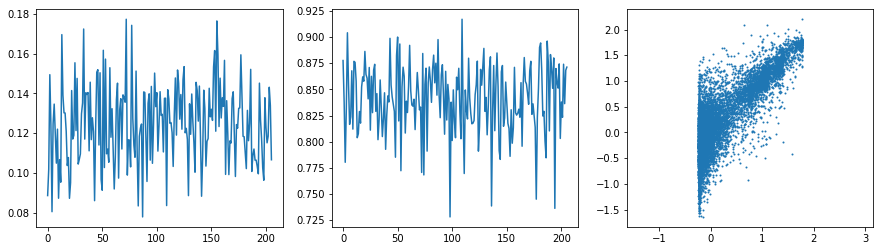

valid loss:  0.12865075502883305
valid correlation:  0.8332189090307079
sota!


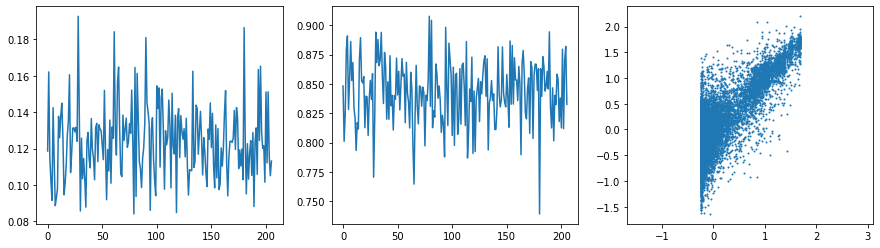

valid loss:  0.12964140640741045
valid correlation:  0.8311388171746131


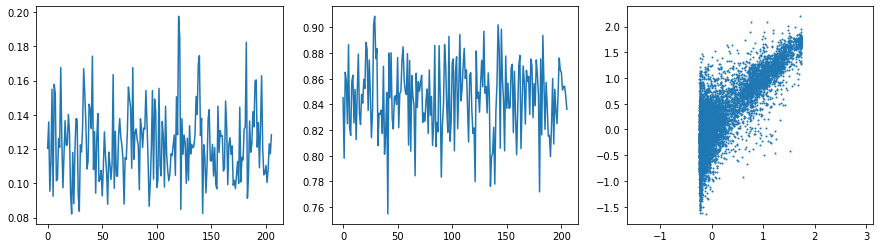

valid loss:  0.12821156802502545
valid correlation:  0.8341819323506042
sota!


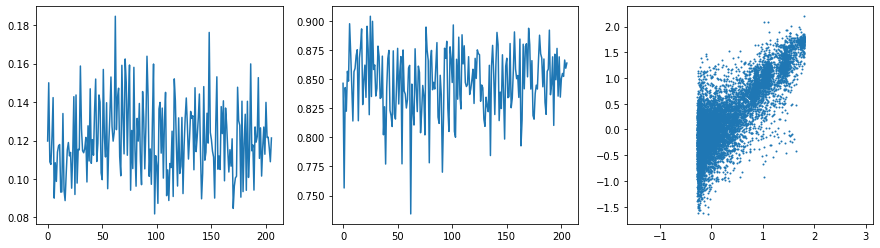

valid loss:  0.14071154010228135
valid correlation:  0.8260619651290232


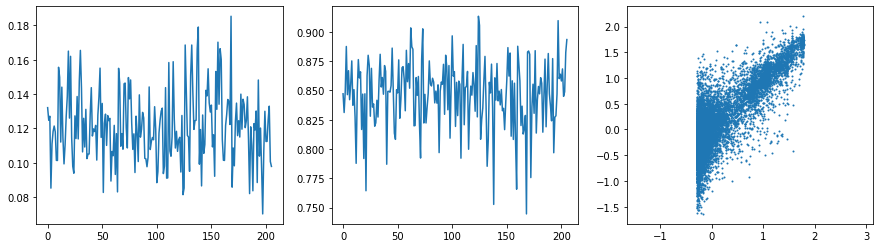

valid loss:  0.1290426544675773
valid correlation:  0.8349219807433093
sota!


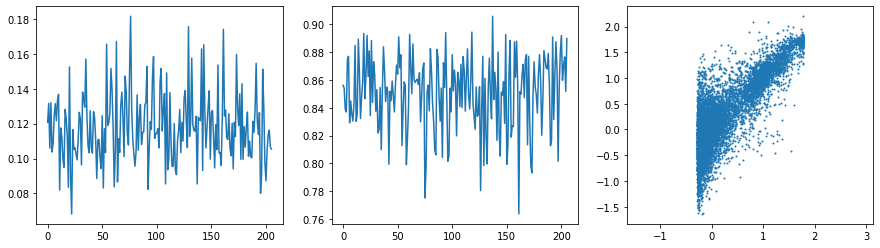

valid loss:  0.12605021800845861
valid correlation:  0.8368852462558773
sota!


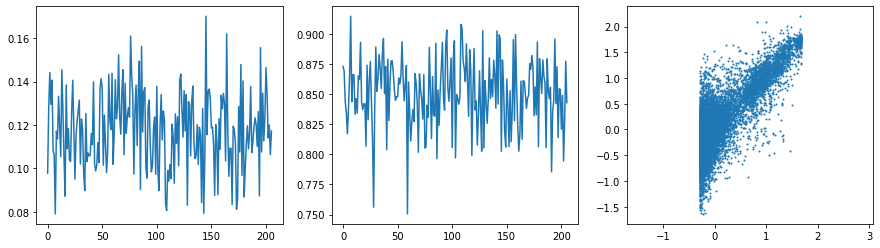

valid loss:  0.1265041423453526
valid correlation:  0.8368621622362102


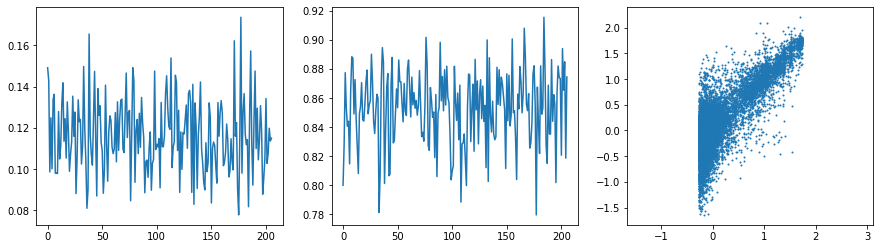

valid loss:  0.12518840774216436
valid correlation:  0.8372328104763818
sota!


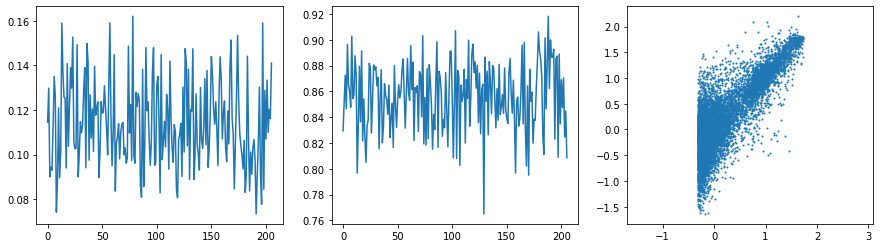

valid loss:  0.1256270897998051
valid correlation:  0.8368908869223015


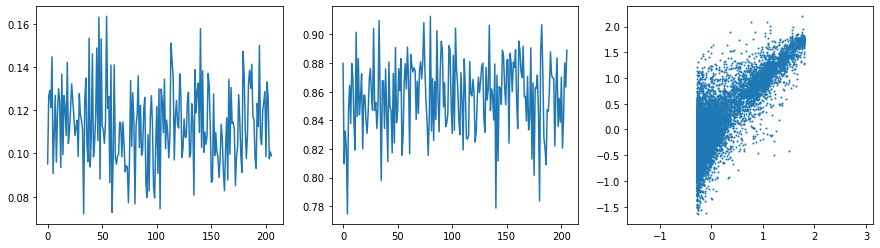

valid loss:  0.12738600483333523
valid correlation:  0.8354316623333844


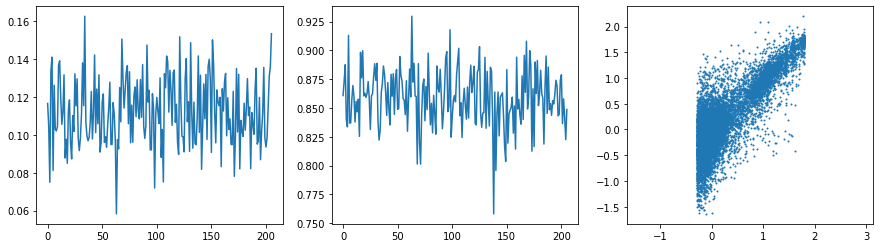

valid loss:  0.12929198416796597
valid correlation:  0.8368749336424481


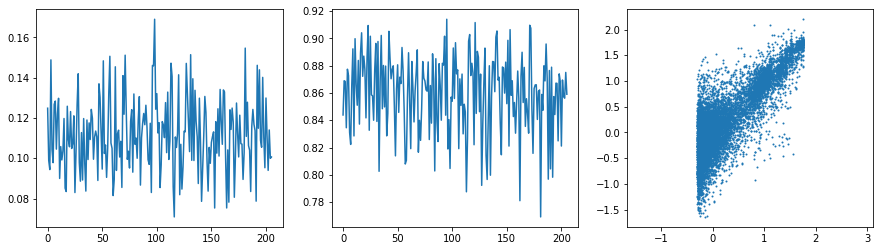

valid loss:  0.12703138970854608
valid correlation:  0.8369602970586849


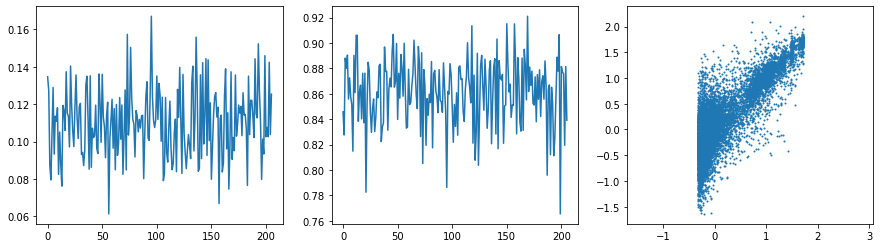

valid loss:  0.12571002593771977
valid correlation:  0.8384510267421227
sota!


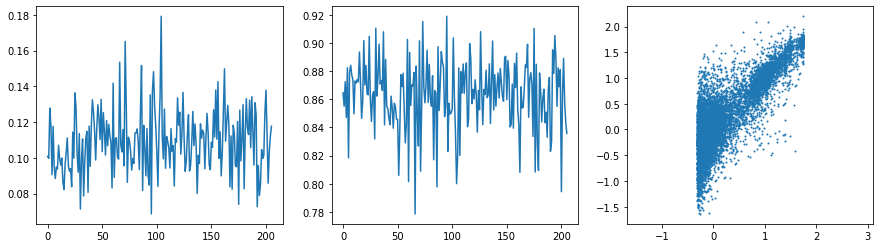

valid loss:  0.12586035079915414
valid correlation:  0.8371259118262269


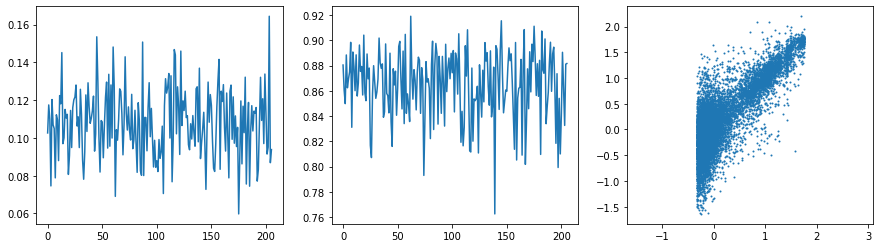

valid loss:  0.12563671806657856
valid correlation:  0.8371193553485939


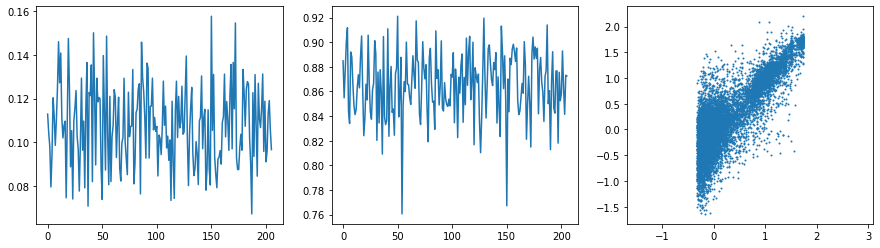

valid loss:  0.1271442420441996
valid correlation:  0.8372305487576701


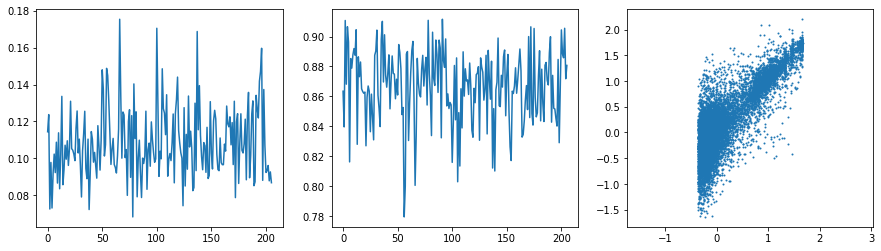

valid loss:  0.1254472846842625
valid correlation:  0.8383559185337488


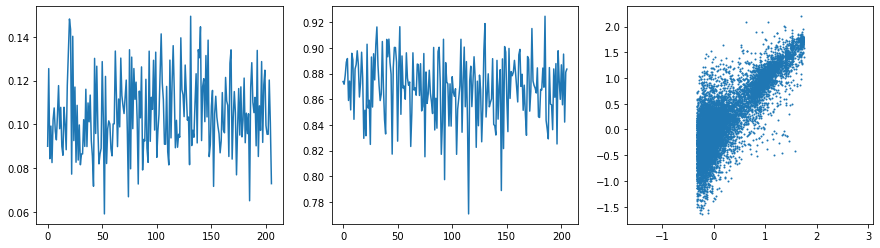

valid loss:  0.1252858087589795
valid correlation:  0.8383824947460793


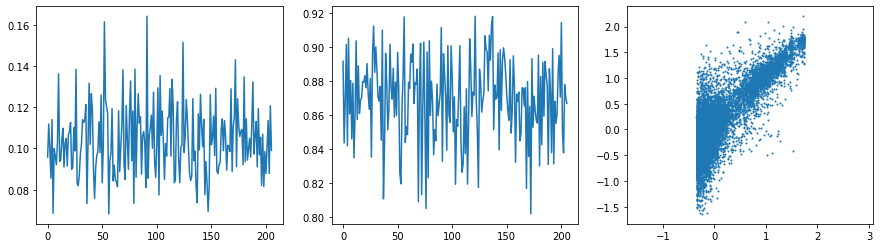

valid loss:  0.12737343815917318
valid correlation:  0.8372260082464514


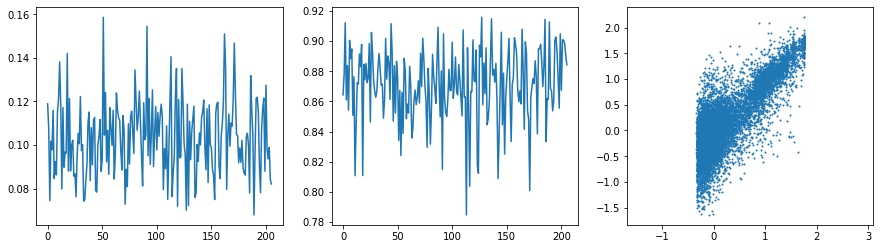

valid loss:  0.13290844722227615
valid correlation:  0.8359528315438365


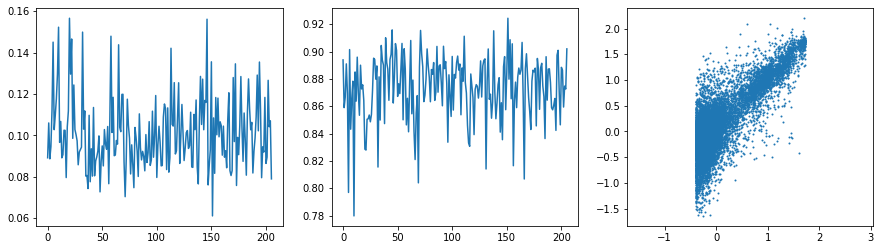

valid loss:  0.1286220265213739
valid correlation:  0.8380332054531286


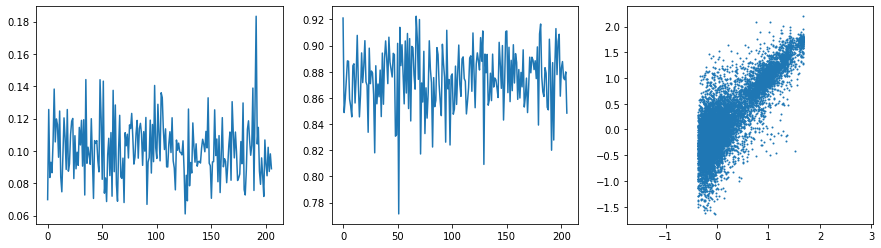

valid loss:  0.12364646563814445
valid correlation:  0.840189892424571
sota!


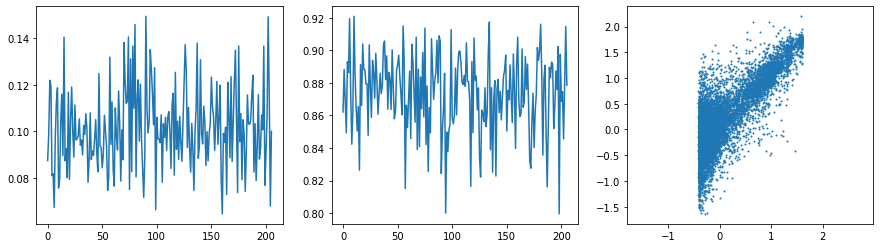

valid loss:  0.13985856978053396
valid correlation:  0.8381084681042508


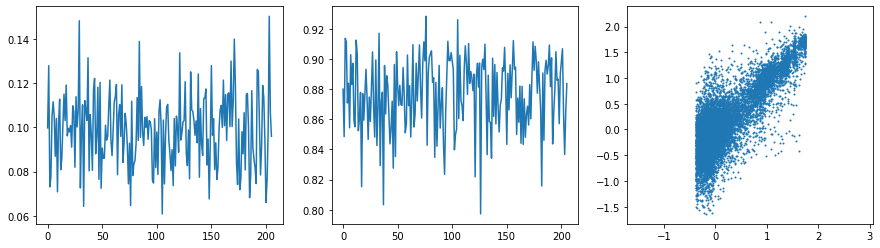

valid loss:  0.13000977818261494
valid correlation:  0.8359757034409271


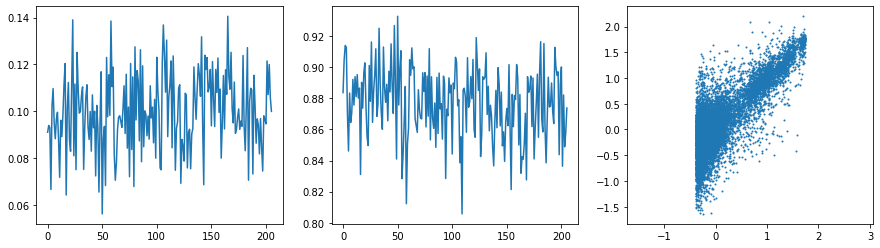

valid loss:  0.12677259929478168
valid correlation:  0.8386285917874375


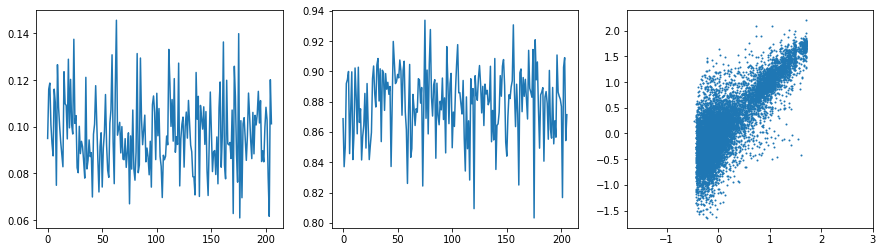

valid loss:  0.12554588668387046
valid correlation:  0.8367819624051083


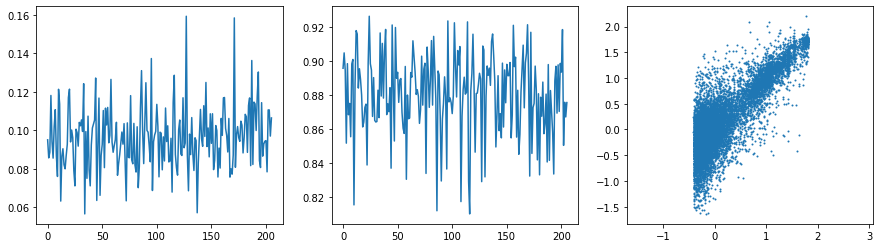

valid loss:  0.12579567290165208
valid correlation:  0.8387868592515731


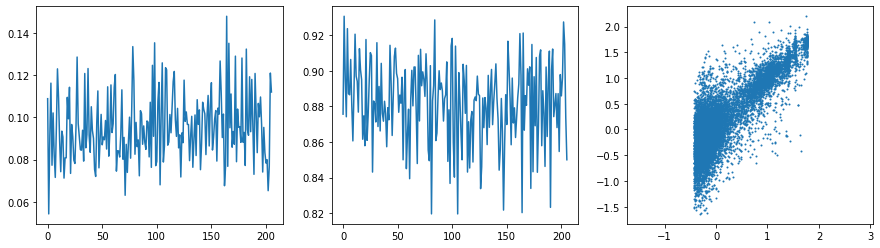

valid loss:  0.1280923429029909
valid correlation:  0.8380460814188773


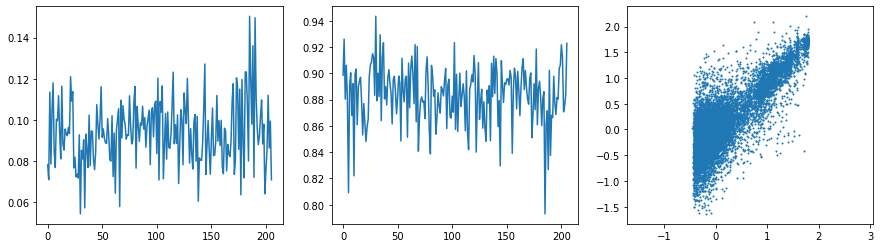

valid loss:  0.13244591221552005
valid correlation:  0.8350502716742452


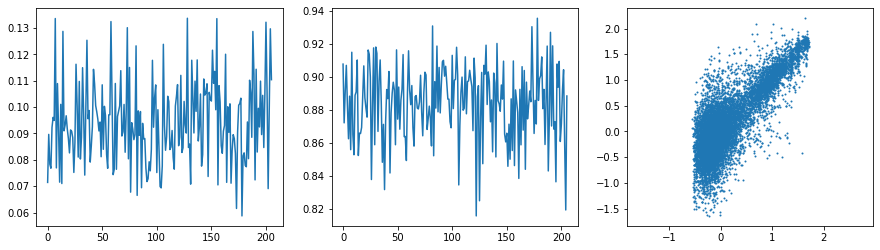

valid loss:  0.1272696296430447
valid correlation:  0.8348777745191105


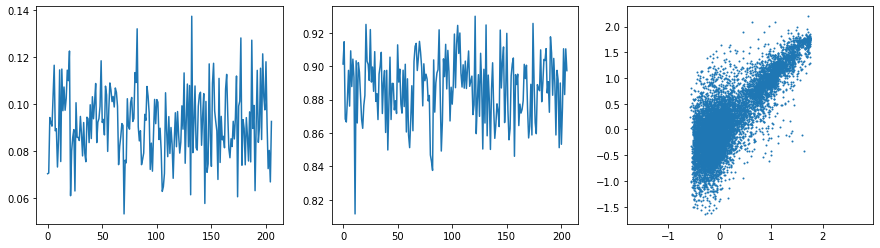

valid loss:  0.13094933187081056
valid correlation:  0.8297665030636627


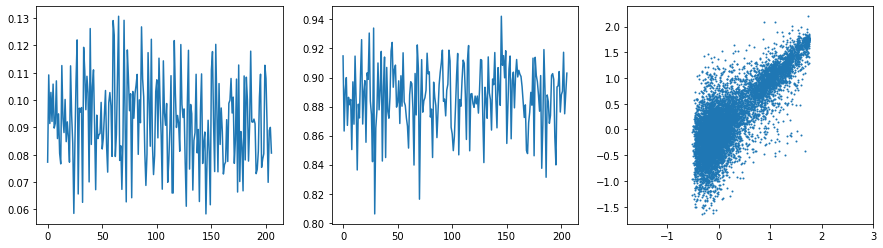

valid loss:  0.128427313556048
valid correlation:  0.8352613526511558


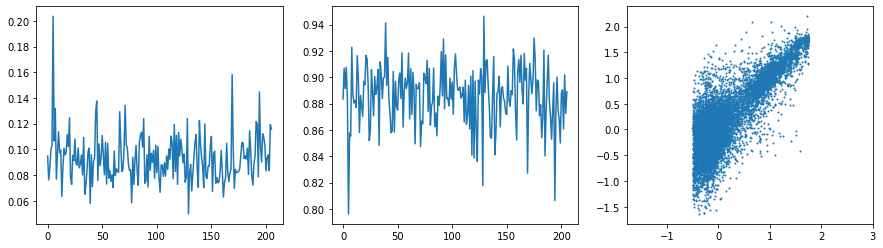

valid loss:  0.12749517996880141
valid correlation:  0.8367042953392283


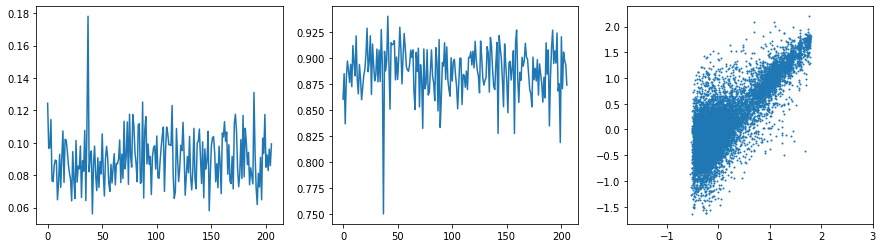

valid loss:  0.1324521086432717
valid correlation:  0.8327544340469446


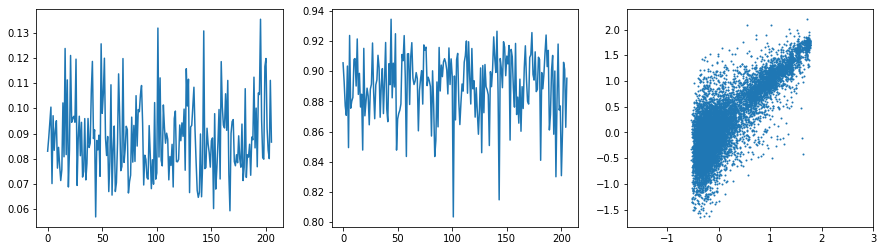

valid loss:  0.12963463899425484
valid correlation:  0.8369666024191749


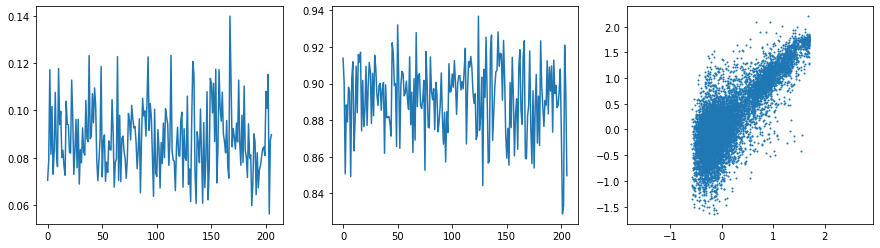

valid loss:  0.12796044874597678
valid correlation:  0.8346217629420486


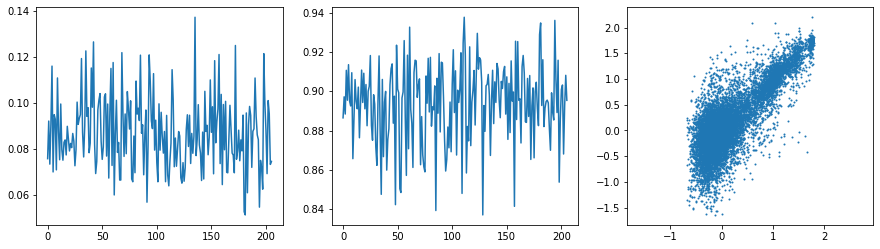

valid loss:  0.12871434996751221
valid correlation:  0.8342336201596545


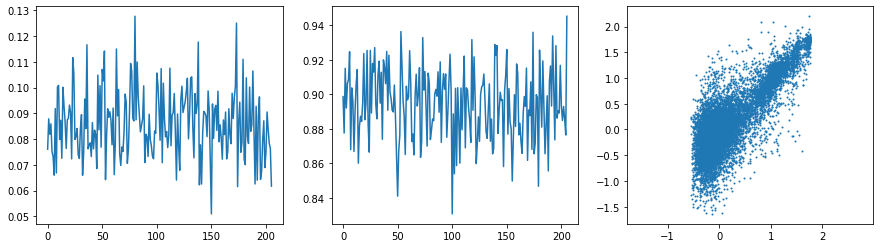

valid loss:  0.1326792406087572
valid correlation:  0.8332703461229432


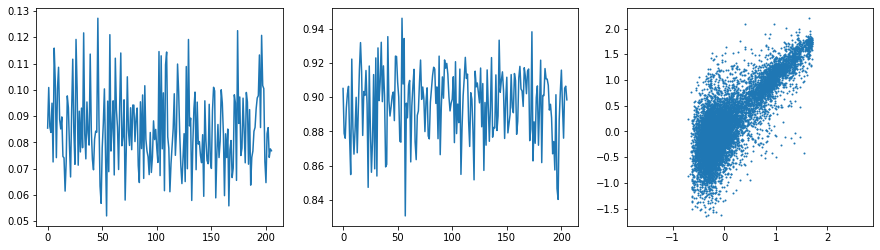

valid loss:  0.13169265309856695
valid correlation:  0.8357771373434055


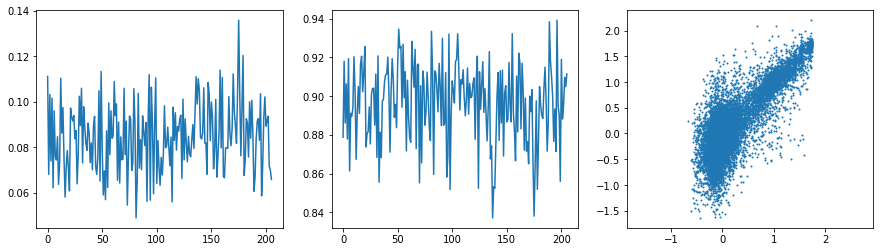

valid loss:  0.13191739850762216
valid correlation:  0.8326005486052743


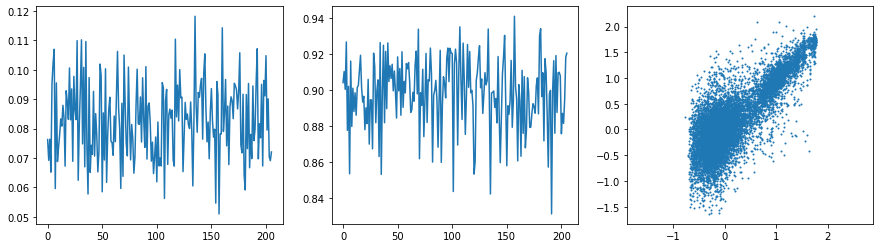

valid loss:  0.133751155808568
valid correlation:  0.8321223329384038


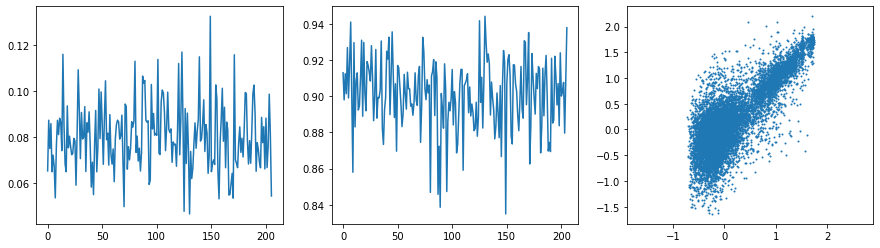

valid loss:  0.13325884150849146
valid correlation:  0.8310782608892215


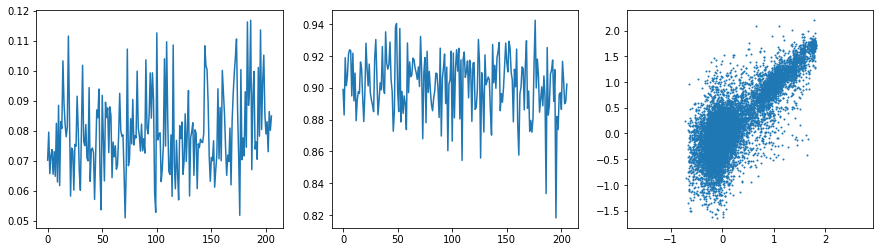

valid loss:  0.1351822553710504
valid correlation:  0.8300553157196771


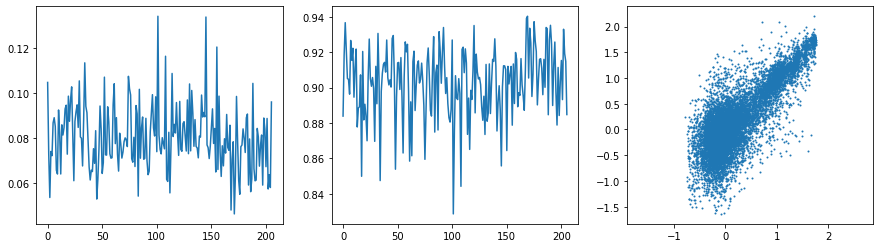

valid loss:  0.13437799686058002
valid correlation:  0.830075840365881


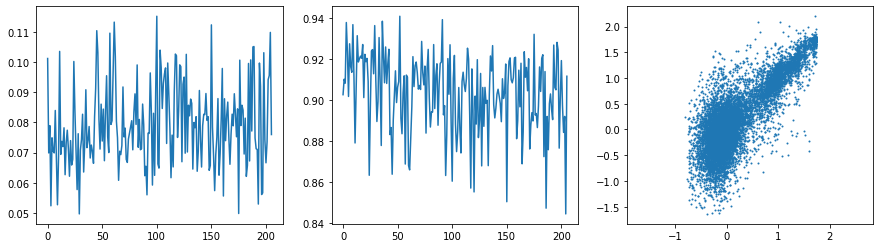

valid loss:  0.13394541606645693
valid correlation:  0.8266262108888661


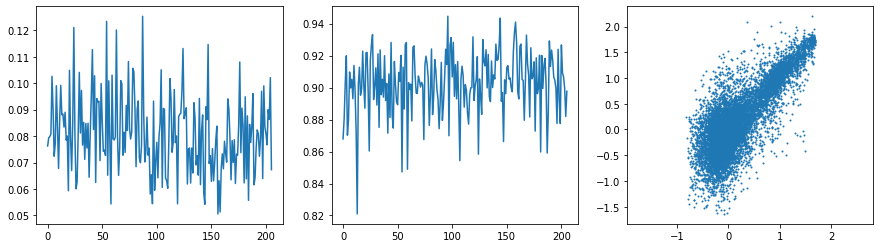

valid loss:  0.1305042142048478
valid correlation:  0.8296434081739915


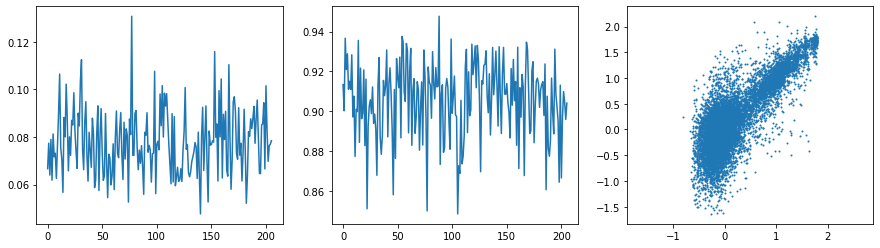

valid loss:  0.12777418177574873
valid correlation:  0.834291964139285


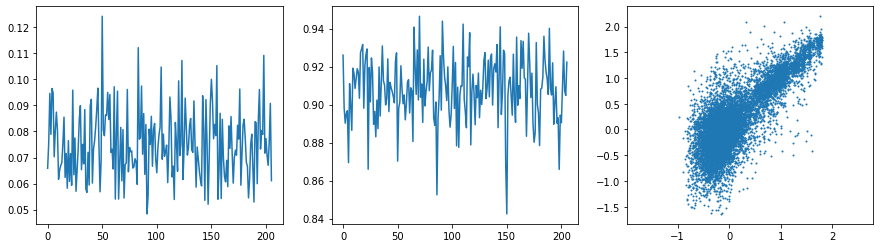

valid loss:  0.13662956189364195
valid correlation:  0.8304805459602456


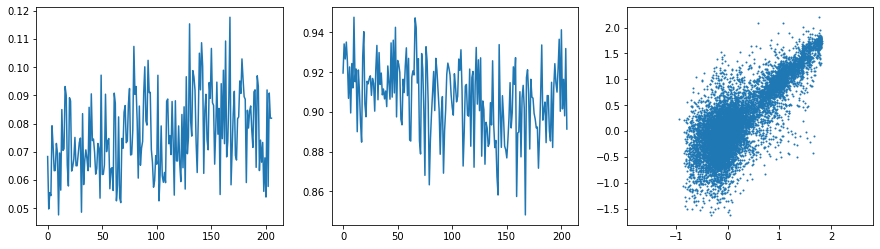

valid loss:  0.13762616374614564
valid correlation:  0.8272475994824604


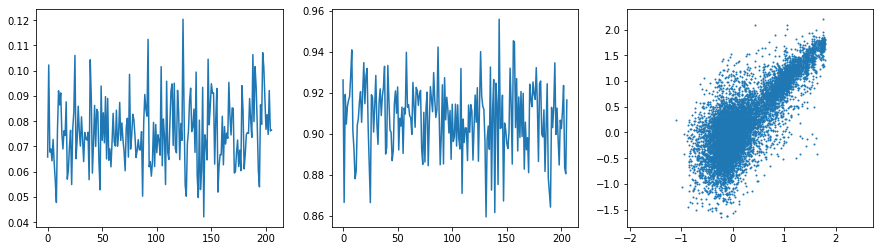

valid loss:  0.13417191337794065
valid correlation:  0.8280221926932554


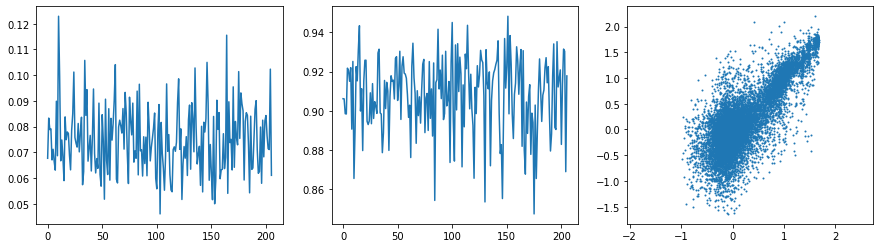

valid loss:  0.14041385968977754
valid correlation:  0.8192441048230431


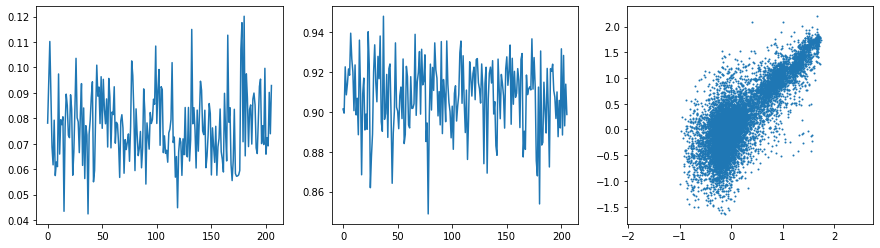

valid loss:  0.1330688881941817
valid correlation:  0.8278201822040991


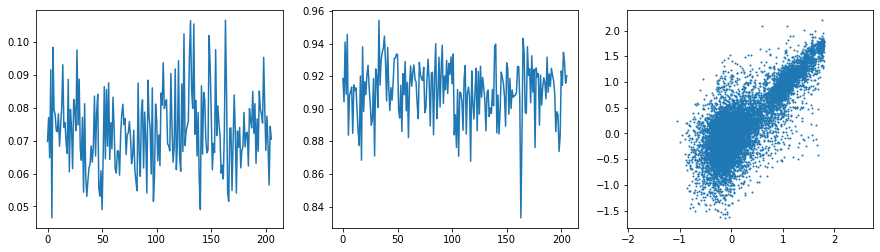

valid loss:  0.14176619171418928
valid correlation:  0.8271499803810934


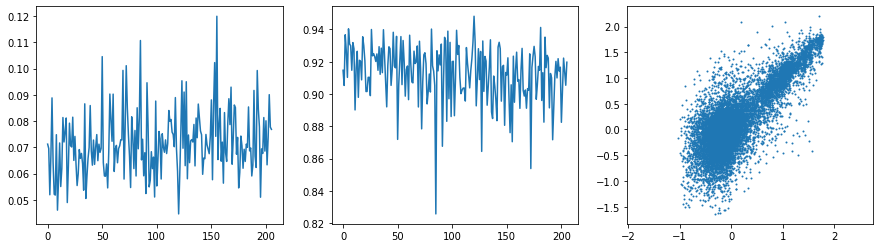

valid loss:  0.13992377599193292
valid correlation:  0.8269854071188746


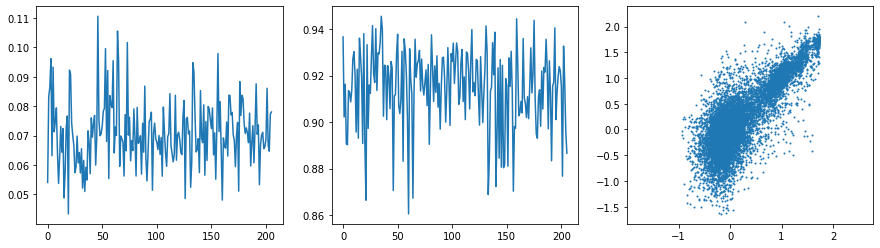

valid loss:  0.13050927509638396
valid correlation:  0.8311154560879167


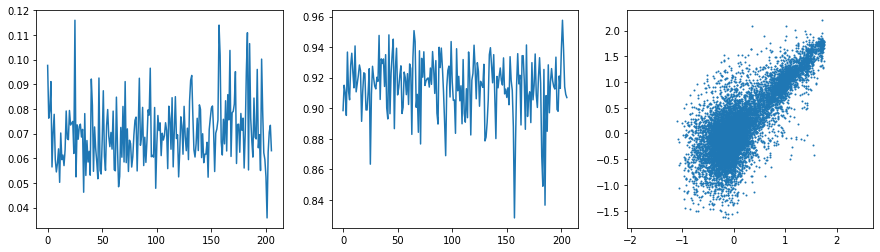

valid loss:  0.13915961752222342
valid correlation:  0.820716148918601


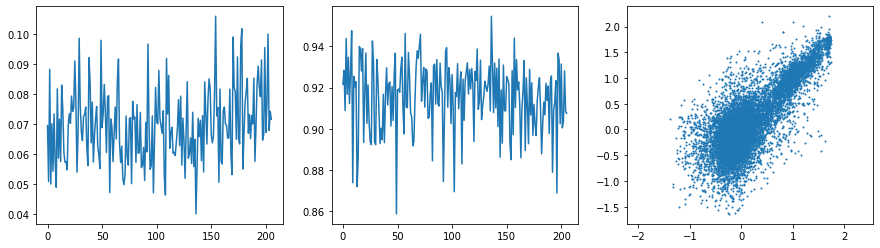

valid loss:  0.14545322218063203
valid correlation:  0.8159479815649924


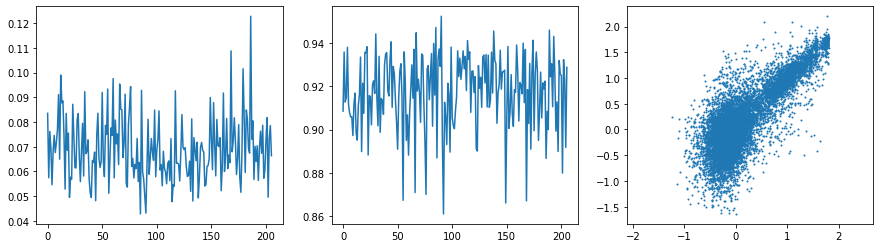

valid loss:  0.13484306184744294
valid correlation:  0.830683796369674


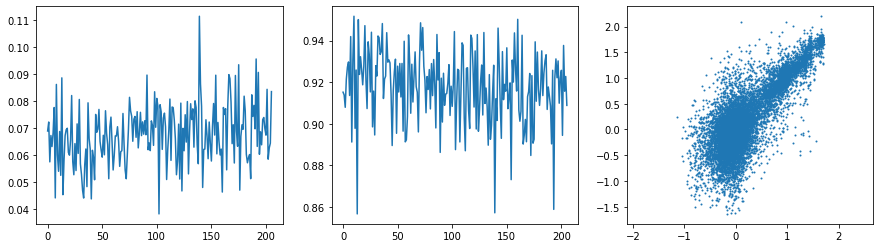

valid loss:  0.13758630838922478
valid correlation:  0.8196184921620531


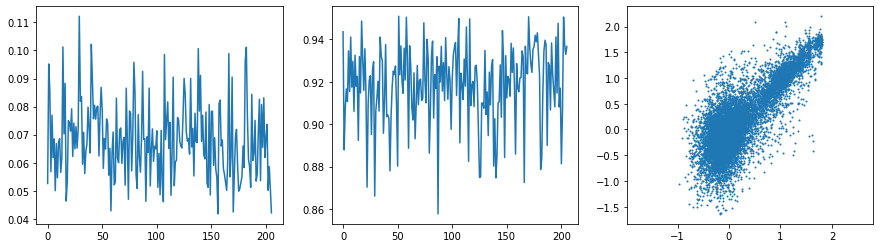

valid loss:  0.13347400132228027
valid correlation:  0.8307945247439287


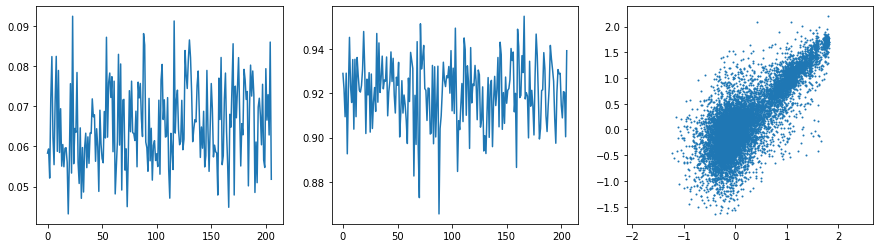

valid loss:  0.14096259622072632
valid correlation:  0.8243440319329594


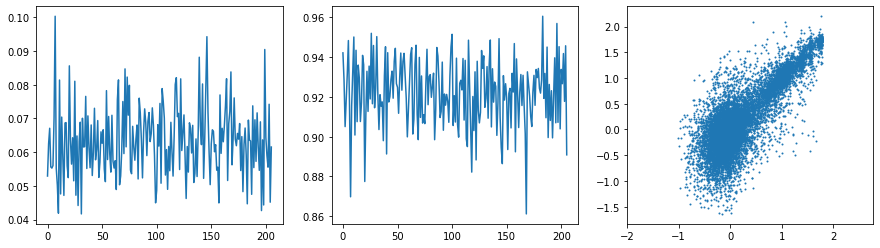

valid loss:  0.13496333970264954
valid correlation:  0.826960525780941


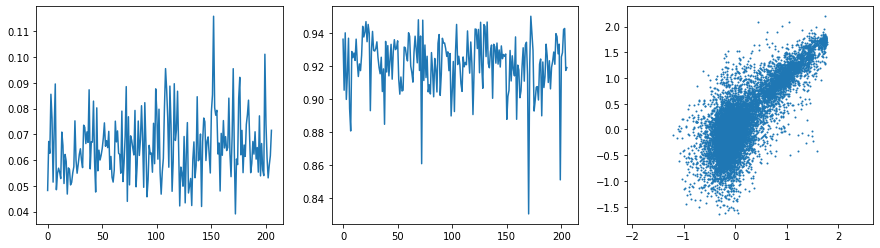

valid loss:  0.1358607956631617
valid correlation:  0.8227755321753196


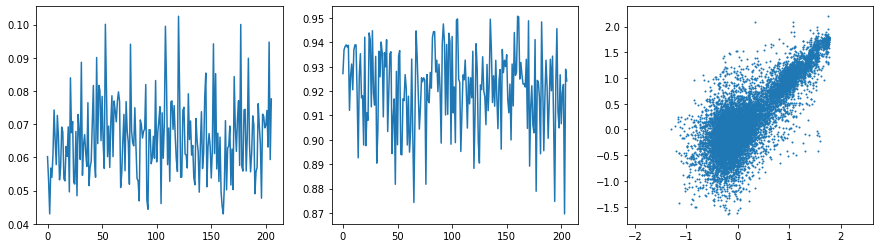

valid loss:  0.14009503867815842
valid correlation:  0.8242063521681171


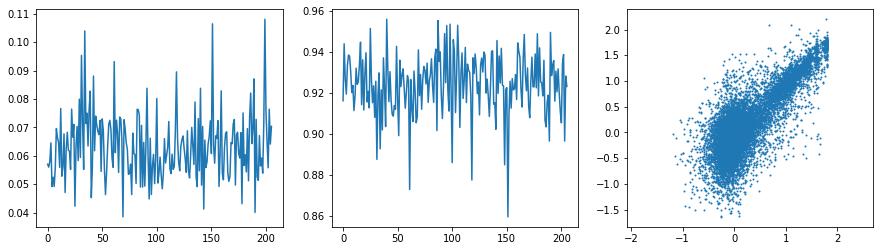

valid loss:  0.1421016390350732
valid correlation:  0.828473951881567


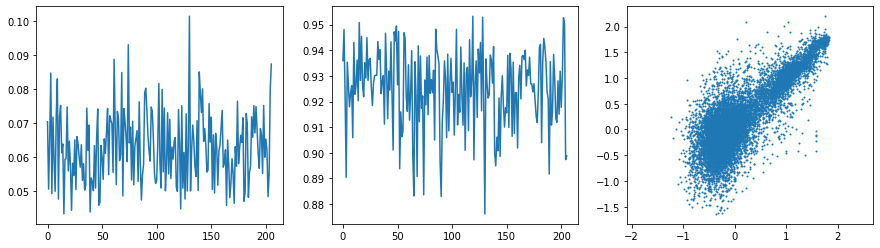

valid loss:  0.14759561554952103
valid correlation:  0.8281062889847008


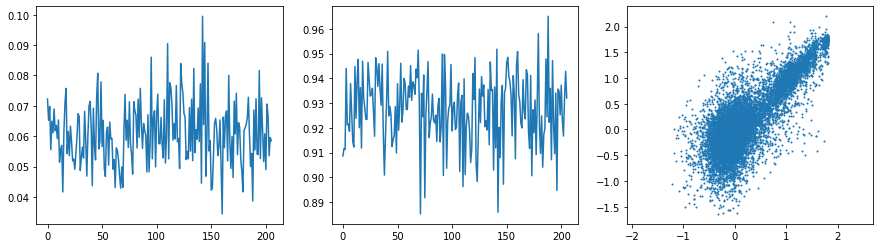

valid loss:  0.14145818301899868
valid correlation:  0.8246478235464156


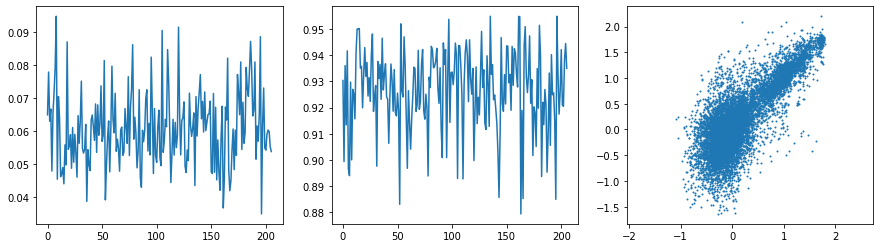

valid loss:  0.13565074135972696
valid correlation:  0.8255517497506092


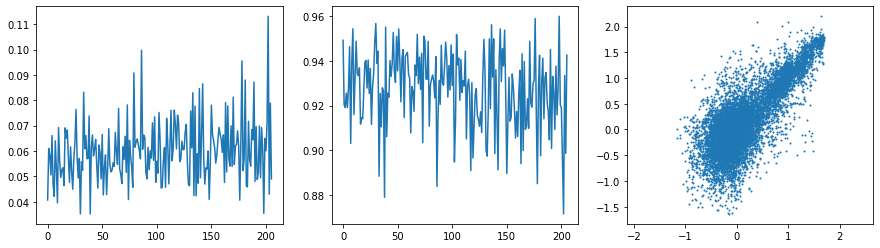

valid loss:  0.1386800646273927
valid correlation:  0.8201859146597539


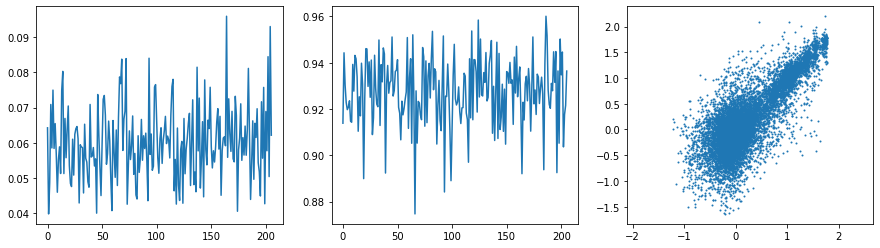

valid loss:  0.1411472809585658
valid correlation:  0.8226182558374175


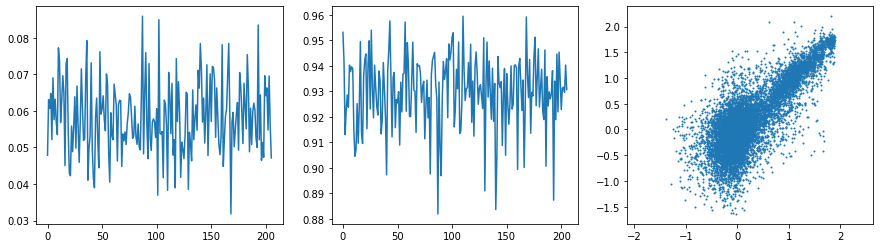

valid loss:  0.14523487682030958
valid correlation:  0.8237160867392312


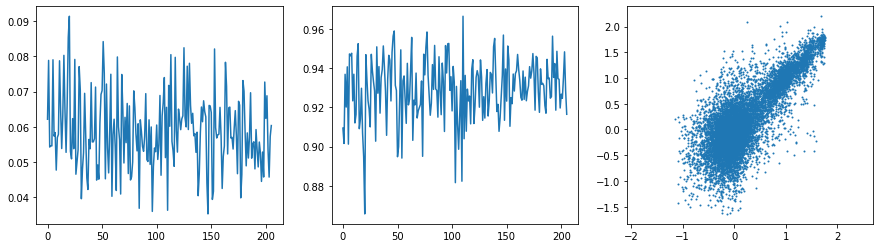

valid loss:  0.13950941533866254
valid correlation:  0.8194197395330081


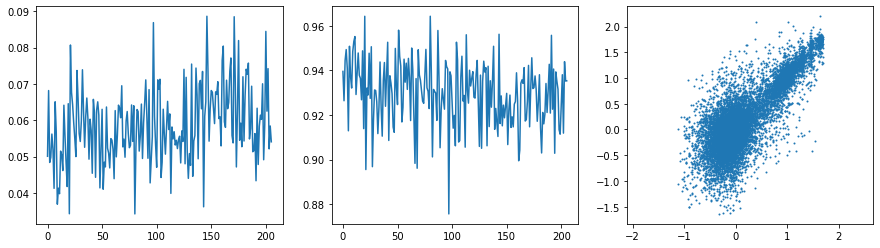

valid loss:  0.13893972396511922
valid correlation:  0.8206996925115699


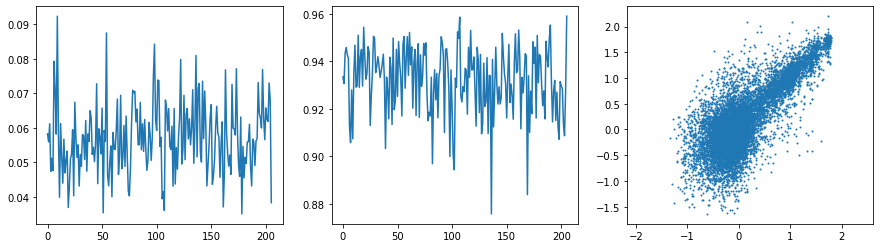

valid loss:  0.15424412378871982
valid correlation:  0.8122265619576448


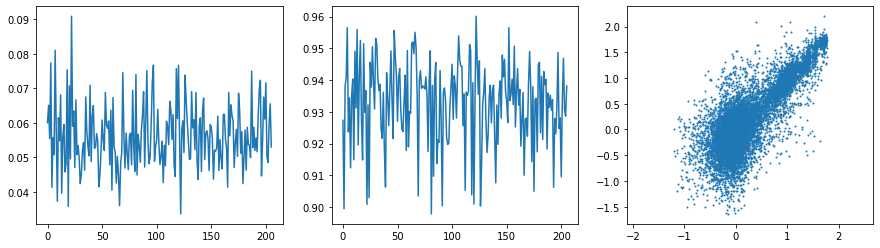

valid loss:  0.13999042939394712
valid correlation:  0.8224929994391916


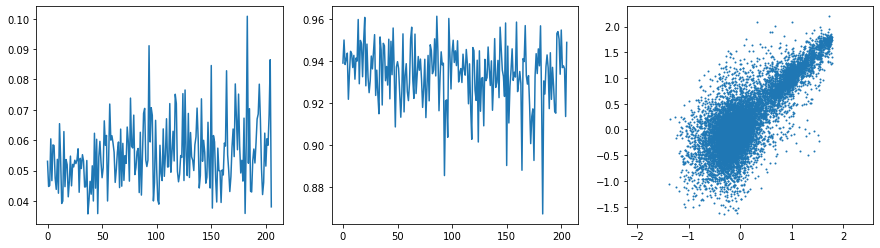

valid loss:  0.1520105701955882
valid correlation:  0.8152553982334153


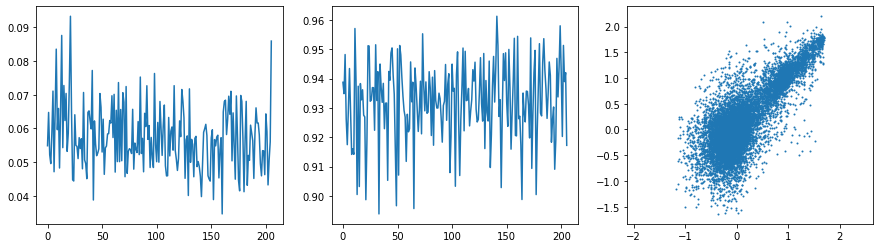

valid loss:  0.14196023819121448
valid correlation:  0.8168232876330147


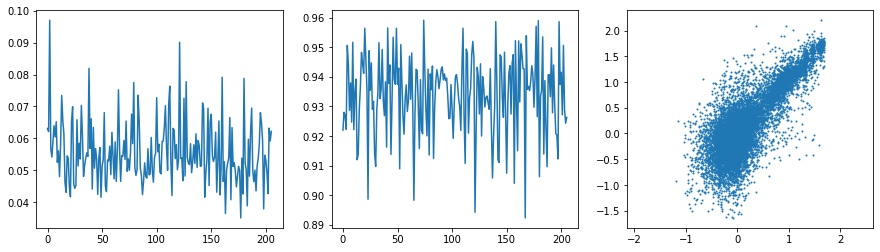

valid loss:  0.13611148119988767
valid correlation:  0.8217517566190096


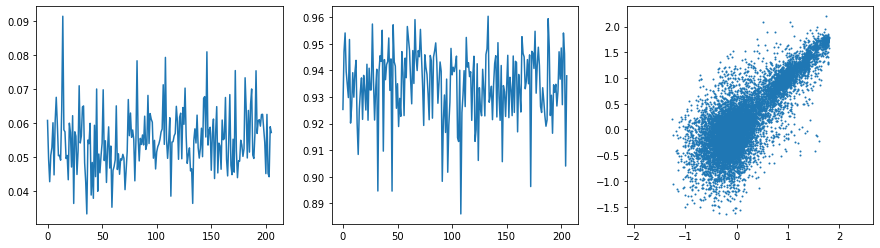

valid loss:  0.1453003552318974
valid correlation:  0.8184059139844226


KeyboardInterrupt: ignored

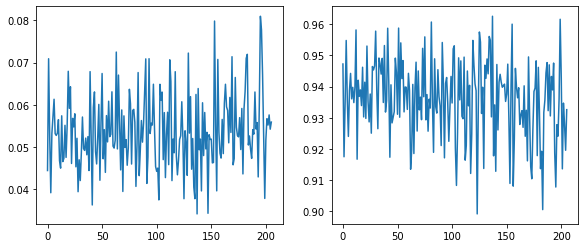

In [75]:

epochs = 200
TRAIN_LOSS = []
TEST_LOSS = []
TRAIN_CORR = []
TEST_CORR = []
plt.rcParams['figure.figsize'] = (15, 4)
for epoch in range(epochs):
    losses = []
    pcces = []
    for batch in dl_train:
        loss1, pcc = train_step(model, batch[0], batch[1], batch[2], batch[3])
        losses.append(loss1)
        pcces.append(pcc)
    TRAIN_LOSS.append(sum(losses) / len(losses))
    TRAIN_CORR.append(sum(pcces) / len(pcces))
    plt.subplot(1,3,1)
    plt.plot(losses)
    plt.subplot(1,3,2)
    plt.plot(pcces)
    
    losses = []
    pcces = []
    preds = []
    labels = []
    for batch in dl_test:
        features = batch[0]#[mask]
        label = batch[1]#[mask]
        loss2, predictions = valid_step(model, features, label, batch[2], batch[3])
        losses.append(loss2)
        for i in range(predictions.shape[0]):
          preds.append(predictions[i].cpu().numpy().item())
          labels.append(label[i].cpu().numpy().item())

    pccs = pearsonr(np.array(preds), np.array(labels))[0]
    TEST_LOSS.append(sum(losses) / len(losses))
    TEST_CORR.append(pccs)
    plt.subplot(1,3,3)
    plt.scatter(preds, labels, s=1)
    plt.axis("equal")
    plt.show()
    print("valid loss: ", sum(losses) / len(losses))
    print("valid correlation: ", pccs)

    if TEST_CORR[-1] == max(TEST_CORR): 
      print("sota!")
      torch.save(model.state_dict(), "./drive/MyDrive/ESM/LSTM_with_Contact_Map_2.pkl")
    

    
    


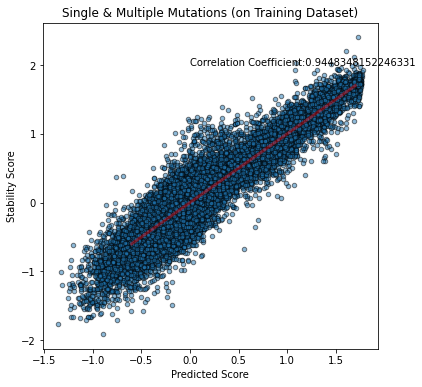

In [76]:
preds = []
labels = []

for batch in dl_train:
    model.eval()

    with torch.no_grad():
        predictions = model(batch[0].to(device), batch[2].to(device), batch[3].to(device)).reshape(-1)
    for i in range(predictions.shape[0]):
      preds.append(predictions[i].cpu().numpy().item())
      labels.append(batch[1][i].cpu().numpy().item())

plt.rcParams['figure.figsize'] = (6, 6)
plt.scatter(preds, labels, s=20, alpha=0.5, edgecolors="black")
plt.text(x=0, y=2, s="Correlation Coefficient:"+str(pearsonr(np.array(preds), np.array(labels))[0]))
plt.plot((-0.6, 1.7), (-0.6, 1.7), "red", alpha=0.4, linewidth=3)
#plt.axis("equal")
plt.ylabel("Stability Score")
plt.xlabel("Predicted Score")
plt.title("Single & Multiple Mutations (on Training Dataset)")
plt.show()

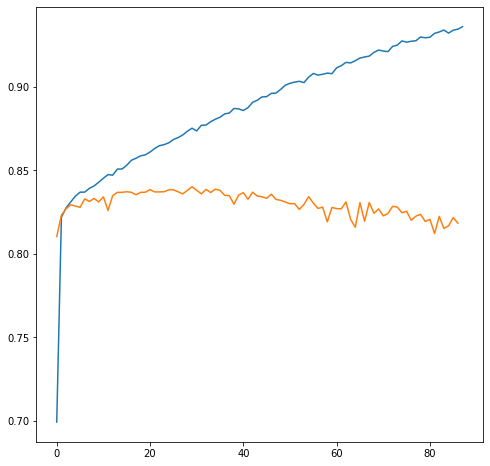

In [77]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(TRAIN_CORR)
plt.plot(TEST_CORR)